In [1]:
import torch
import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from pathlib import Path

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog
from bliss.encoder.encoder import Encoder

from pytorch_lightning.utilities import move_data_to_device

from case_studies.dc2_cataloging.utils.bootstrap_tile_cat import bootstrap_tile_cat
from case_studies.dc2_cataloging.utils.lsst_predictor import LSSTPredictor
from case_studies.dc2_cataloging.utils.notebook_variables import NoteBookVariables

output_dir = Path("./classification_bootstrap_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-11-2/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
tile_slen = notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = notebook_cfg.encoder.min_flux_for_metrics

dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

bliss_encoder: Encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder = bliss_encoder.eval()

In [4]:
lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile)

In [5]:
def move_tile_cat_to_device(ori_tile_cat: TileCatalog, device):
    tile_dict = move_data_to_device(ori_tile_cat.data, device=device)
    return TileCatalog(ori_tile_cat.tile_slen, tile_dict)

In [6]:
bliss_tile_cat_list = []
lsst_tile_cat_list = []
target_tile_cat_list = []
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch_on_device = move_data_to_device(batch, device=device)
    target_tile_cat = TileCatalog(tile_slen, batch["tile_catalog"])
    target_tile_cat = target_tile_cat.filter_by_flux(
            min_flux=r_band_min_flux,
            band=2,  # default is r band
        )
    with torch.no_grad():
        bliss_tile_cat = bliss_encoder.sample(batch_on_device, use_mode=True)
        bliss_tile_cat = bliss_tile_cat.filter_by_flux(
            min_flux=r_band_min_flux,
            band=2,
        )
    target_tile_cat_list.append(move_tile_cat_to_device(target_tile_cat, device="cpu"))
    bliss_tile_cat_list.append(move_tile_cat_to_device(bliss_tile_cat, device="cpu"))
    
    wcs_header_str_list = batch["wcs_header_str"]
    image_lim = batch["images"].shape[2]
    height_index_list = batch["image_height_index"].tolist()
    width_index_list = batch["image_width_index"].tolist()
    lsst_tile_cat = lsst_predictor.predict(wcs_header_str_list, 
                                                image_lim, 
                                                height_index_list, 
                                                width_index_list)
    lsst_tile_cat_list.append(lsst_tile_cat)

100%|██████████| 391/391 [18:58<00:00,  2.91s/it]


In [7]:
# bootstrap
matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_metrics = instantiate(notebook_cfg.encoder.mode_metrics)
bliss_metrics = bliss_metrics["source_type_accuracy"]
lsst_metrics = bliss_metrics.clone()

bliss_internal_states = {}
lsst_internal_states = {}

epochs_num = 10
for epoch in range(epochs_num):
    print(f"Epoch: {epoch}")
    seed = random.randint(1e4, 1e5 - 1)
    for bliss_tile_cat, lsst_tile_cat, target_tile_cat in tqdm.tqdm(zip(bliss_tile_cat_list, 
                                                                        lsst_tile_cat_list, 
                                                                        target_tile_cat_list)):
        bliss_full_cat = bootstrap_tile_cat(bliss_tile_cat, seed=seed).to_full_catalog()
        lsst_full_cat = bootstrap_tile_cat(lsst_tile_cat, seed=seed).to_full_catalog()
        target_full_cat = bootstrap_tile_cat(target_tile_cat, seed=seed).to_full_catalog()

        bliss_matching = matcher.match_catalogs(target_full_cat, bliss_full_cat)
        bliss_metrics.update(target_full_cat, bliss_full_cat, bliss_matching)

        lsst_matching = matcher.match_catalogs(target_full_cat, lsst_full_cat)
        lsst_metrics.update(target_full_cat, lsst_full_cat, lsst_matching)

    internal_states = bliss_metrics.get_internal_states()
    for k_state, v_state in internal_states.items():
        if k_state not in bliss_internal_states:
            bliss_internal_states[k_state] = []
        bliss_internal_states[k_state].append(v_state)

    internal_states = lsst_metrics.get_internal_states()
    for k_state, v_state in internal_states.items():
        if k_state not in lsst_internal_states:
            lsst_internal_states[k_state] = []
        lsst_internal_states[k_state].append(v_state)

    bliss_metrics.reset()
    lsst_metrics.reset()

bliss_internal_states = {k: torch.stack(v) for k, v in bliss_internal_states.items()}
lsst_internal_states = {k: torch.stack(v) for k, v in lsst_internal_states.items()}

Epoch: 0


391it [01:57,  3.31it/s]


Epoch: 1


391it [01:50,  3.54it/s]


Epoch: 2


391it [01:50,  3.53it/s]


Epoch: 3


391it [01:50,  3.55it/s]


Epoch: 4


391it [01:49,  3.56it/s]


Epoch: 5


391it [01:46,  3.67it/s]


Epoch: 6


391it [01:45,  3.71it/s]


Epoch: 7


391it [01:45,  3.69it/s]


Epoch: 8


391it [01:48,  3.62it/s]


Epoch: 9


391it [01:40,  3.91it/s]


In [16]:
plt.rcParams.update({"font.size": NoteBookVariables.font_size})

def plot_with_error_bar(bliss_matrix, lsst_matrix, flux_bin_cutoffs, y_axis_name):
    xlabels = (
        ["[100, " + str(flux_bin_cutoffs[0]) + "]"]
        + [f"[{flux_bin_cutoffs[i]}, {flux_bin_cutoffs[i + 1]}]" for i in range(len(flux_bin_cutoffs) - 1)]
        + ["> " + str(flux_bin_cutoffs[-1])]
    )

    sns.set_theme(style="whitegrid")
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    fig, ax = plt.subplots(1, 1, figsize=NoteBookVariables.figsize)

    x = list(range(len(xlabels)))
    ax.plot(x, 
            bliss_matrix[1, :],
            "-o",
            color=color_list[0],
            label="BLISS")
    ax.fill_between(x,
                    bliss_matrix[0, :],
                    bliss_matrix[2, :],
                    color=color_list[0],
                    alpha=0.5)
    ax.plot(x,
            lsst_matrix[1, :],
            "-o",
            color=color_list[1],
            label="LSST")
    ax.fill_between(x,
                    lsst_matrix[0, :],
                    lsst_matrix[2, :],
                    color=color_list[1],
                    alpha=0.5)
    ax.set_xlabel("Flux (nJy)")
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_ylabel(y_axis_name)
    ax.legend()

    fig.tight_layout()

    return fig


In [17]:
def calculate_acc(internal_states: torch.Tensor, quantile_points: torch.Tensor):
    acc = ((internal_states["gal_tp"] + internal_states["star_tp"]) / internal_states["n_matches"]).nan_to_num(0)
    star_acc = (internal_states["star_tp"] / (internal_states["n_matches"] - internal_states["gal_tp"] - internal_states["star_fp"])).nan_to_num(0)
    gal_acc = (internal_states["gal_tp"] / (internal_states["n_matches"] - internal_states["star_tp"] - internal_states["gal_fp"])).nan_to_num(0)
    acc = acc.quantile(q=quantile_points, dim=0)
    star_acc = star_acc.quantile(q=quantile_points, dim=0)
    gal_acc = gal_acc.quantile(q=quantile_points, dim=0)
    return acc, star_acc, gal_acc

In [18]:
quantile_points = torch.tensor([0.05, 0.5, 0.95])

bliss_acc_matrix, bliss_star_acc_matrix, bliss_gal_acc_matrix = calculate_acc(bliss_internal_states, quantile_points=quantile_points)
lsst_acc_matrix, lsst_star_acc_matrix, lsst_gal_acc_matrix = calculate_acc(lsst_internal_states, quantile_points=quantile_points)

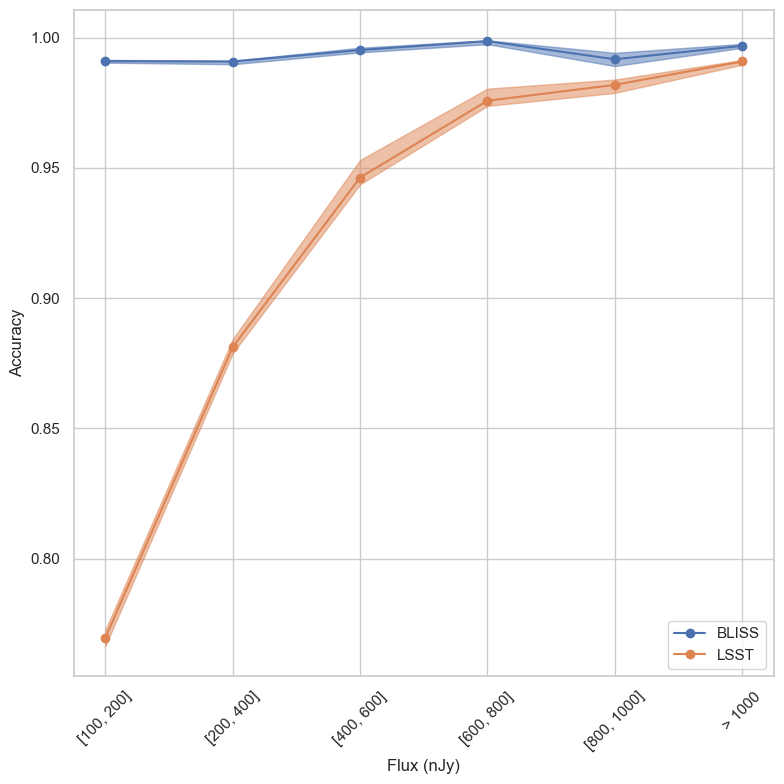

In [19]:
acc_fig = plot_with_error_bar(bliss_acc_matrix, lsst_acc_matrix, 
                              flux_bin_cutoffs=bliss_metrics.flux_bin_cutoffs,
                              y_axis_name="Accuracy")
acc_fig.savefig(output_dir / "classification_acc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
acc_fig.show()

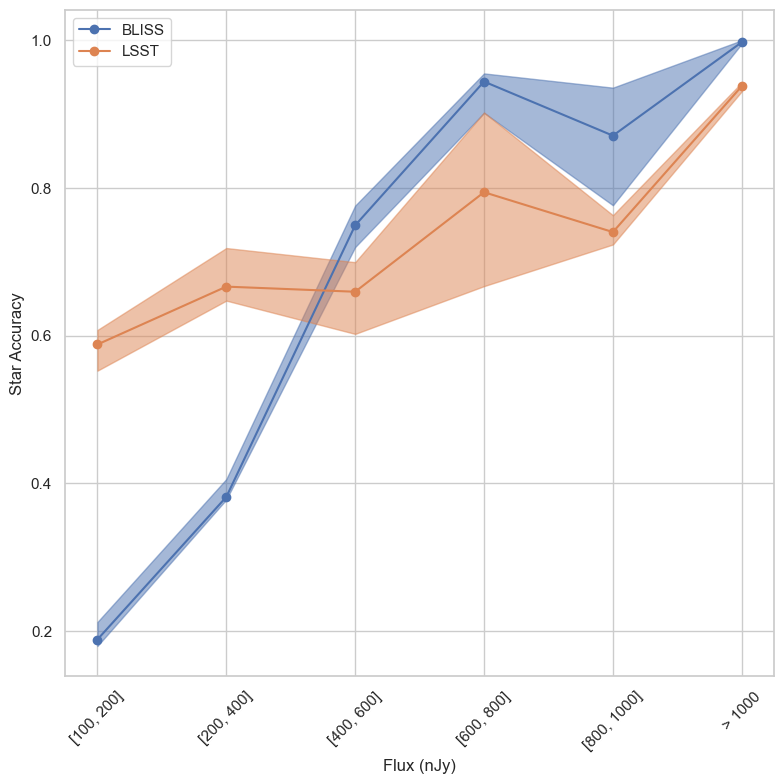

In [20]:
star_acc_fig = plot_with_error_bar(bliss_star_acc_matrix, lsst_star_acc_matrix, 
                                   flux_bin_cutoffs=bliss_metrics.flux_bin_cutoffs,
                                   y_axis_name="Star Accuracy")
star_acc_fig.savefig(output_dir / "classification_star_acc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
star_acc_fig.show()

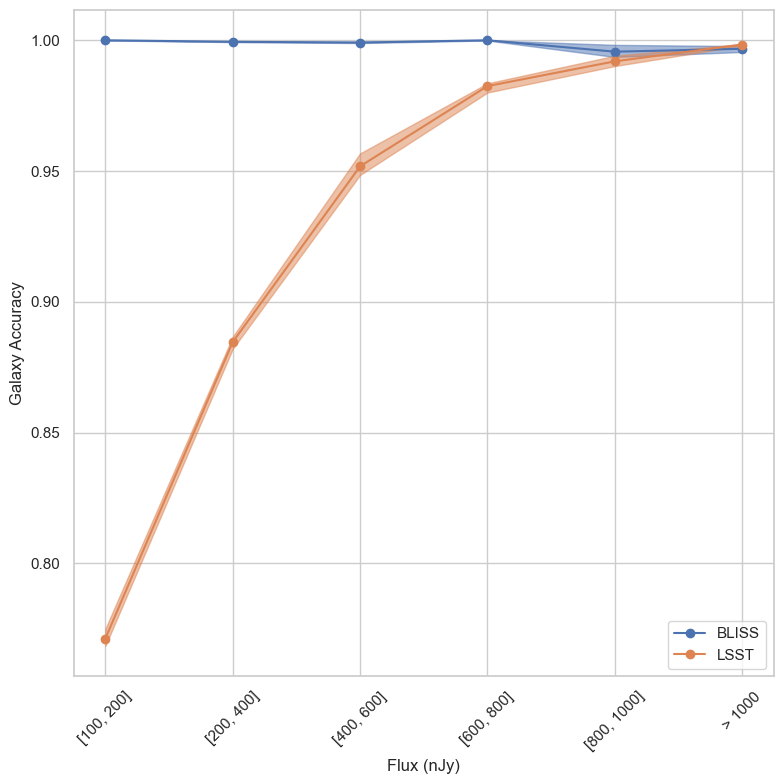

In [21]:
gal_acc_fig = plot_with_error_bar(bliss_gal_acc_matrix, lsst_gal_acc_matrix, 
                                  flux_bin_cutoffs=bliss_metrics.flux_bin_cutoffs,
                                  y_axis_name="Galaxy Accuracy")
gal_acc_fig.savefig(output_dir / "classification_galaxy_acc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
gal_acc_fig.show()

In [24]:
def calculate_f1(internal_states, quantile_points):
    gal_recall = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["star_fp"])
    gal_precision = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["gal_fp"])
    star_recall = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["gal_fp"])
    star_precision = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["star_fp"])
    gal_f1 = 2 * gal_precision * gal_recall / (gal_precision + gal_recall)
    star_f1 = 2 * star_precision * star_recall / (star_precision + star_recall)
    gal_f1 = gal_f1.quantile(q=quantile_points, dim=0)
    star_f1 = star_f1.quantile(q=quantile_points, dim=0)
    return gal_f1, star_f1

In [29]:
bliss_gal_f1_matrix, bliss_star_f1_matrix = calculate_f1(bliss_internal_states, quantile_points=quantile_points)
lsst_gal_f1_matrix, lsst_star_f1_matrix = calculate_f1(lsst_internal_states, quantile_points=quantile_points)

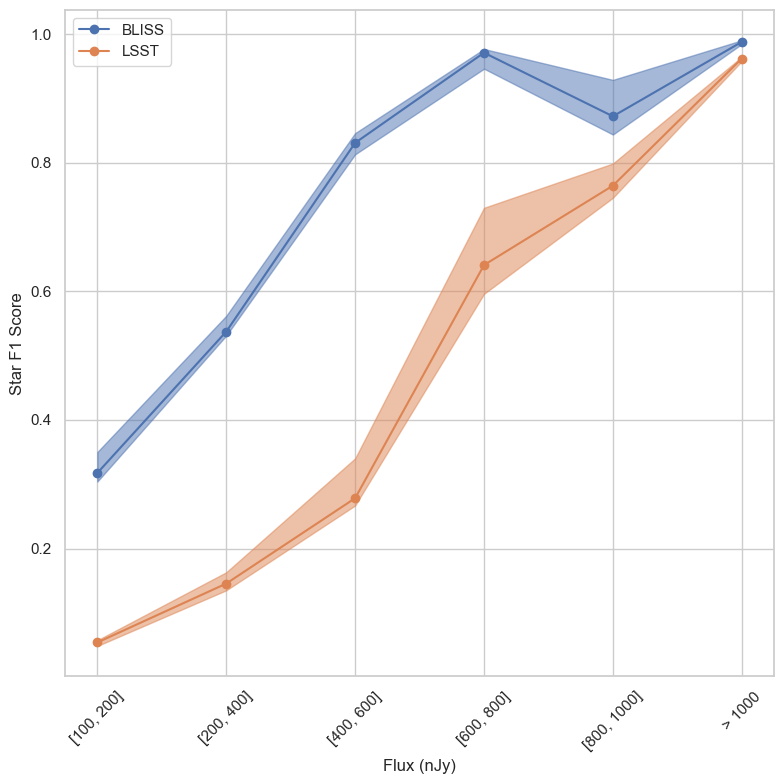

In [30]:
star_f1_fig = plot_with_error_bar(bliss_star_f1_matrix, lsst_star_f1_matrix, 
                             flux_bin_cutoffs=bliss_metrics.flux_bin_cutoffs,
                             y_axis_name="Star F1 Score")
star_f1_fig.savefig(output_dir / "classification_star_f1.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
star_f1_fig.show()

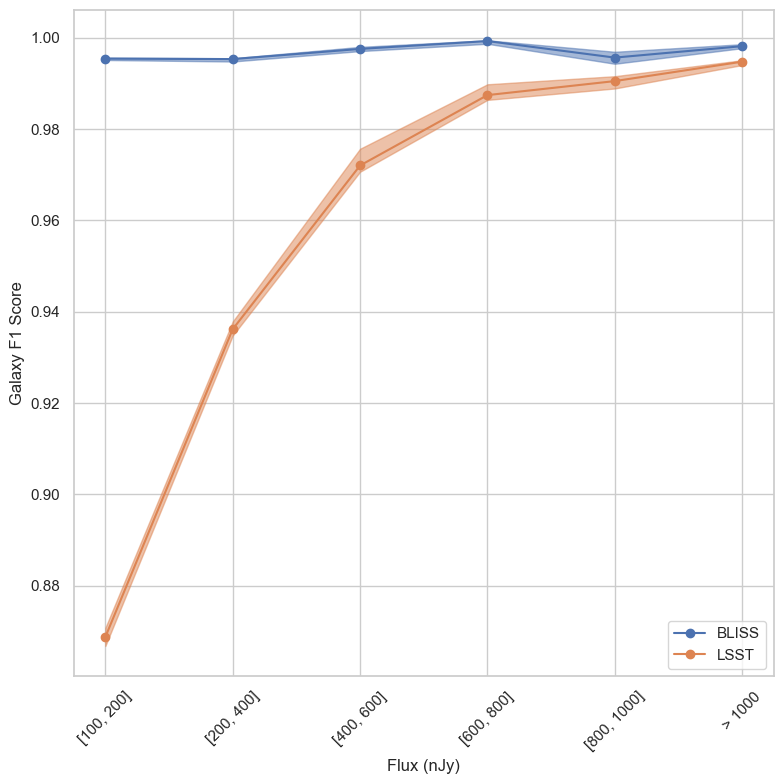

In [31]:
gal_f1_fig = plot_with_error_bar(bliss_gal_f1_matrix, lsst_gal_f1_matrix, 
                             flux_bin_cutoffs=bliss_metrics.flux_bin_cutoffs,
                             y_axis_name="Galaxy F1 Score")
gal_f1_fig.savefig(output_dir / "classification_gal_f1.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
gal_f1_fig.show()